In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
conf_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
reco_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
deat_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

conf_data_raw = pd.read_csv(conf_url)
reco_data_raw = pd.read_csv(reco_url)
deat_data_raw = pd.read_csv(deat_url)
## confirmed data
conf_data_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/22,12/2/22,12/3/22,12/4/22,12/5/22,12/6/22,12/7/22,12/8/22,12/9/22,12/10/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,206073,206133,206145,206206,206273,206331,206414,206465,206504,206543
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,333360,333381,333391,333408,333413,333455,333472,333490,333491,333521
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271096,271100,271102,271107,271113,271122,271128,271135,271140,271146
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47219,47219,47219,47219,47219,47219,47446,47446,47446,47446
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,104676,104676,104676,104676,104750,104750,104808,104808,104808,104808


In [4]:
## death data
deat_data_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/22,12/2/22,12/3/22,12/4/22,12/5/22,12/6/22,12/7/22,12/8/22,12/9/22,12/10/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7834,7834,7834,7834,7835,7835,7837,7839,7839,7839
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3594,3594,3594,3594,3594,3594,3594,3594,3594,3594
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,157,157,157,157,157,157,158,158,158,158
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1924,1924,1924,1924,1925,1925,1925,1925,1925,1925


Preprocessing of 3 datasets

In [5]:
## transfer all dataframe in to the form of (row: time, col: # of cases)

conf_data = conf_data_raw[conf_data_raw.columns[4:]]
conf_data = conf_data.sum(axis=0)
conf_data = pd.DataFrame(conf_data)

reco_data = reco_data_raw[reco_data_raw.columns[4:]]
reco_data = reco_data.sum(axis=0)
reco_data = pd.DataFrame(reco_data)

deat_data = deat_data_raw[deat_data_raw.columns[4:]]
deat_data = deat_data.sum(axis=0)
deat_data = pd.DataFrame(deat_data)

In [6]:
def get_daily(a):
  b = pd.DataFrame()
  b[a.columns[0]] = a[a.columns[0]]
  for i in range(1,len(a.columns)):
    b[a.columns[i]] = a[a.columns[i]] - a[a.columns[i-1]]
  return b

In [7]:
## find everyday data
conf_data_dai = get_daily(conf_data.transpose()).transpose()
reco_data_dai = get_daily(reco_data.transpose()).transpose()
deat_data_dai = get_daily(deat_data.transpose()).transpose()
conf_data_dai

<ipython-input-6-4729dc443b08>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  b[a.columns[i]] = a[a.columns[i]] - a[a.columns[i-1]]


,0
1/22/20,557
1/23/20,100
1/24/20,287
1/25/20,493
1/26/20,683
...,...
12/6/22,620796
12/7/22,625890
12/8/22,802089
12/9/22,663805


In [8]:
## daily recovery data due to unknown reason have extremly small negative value
reco_data_dai[reco_data_dai[0]<0]=0

Visulization of 3 data set

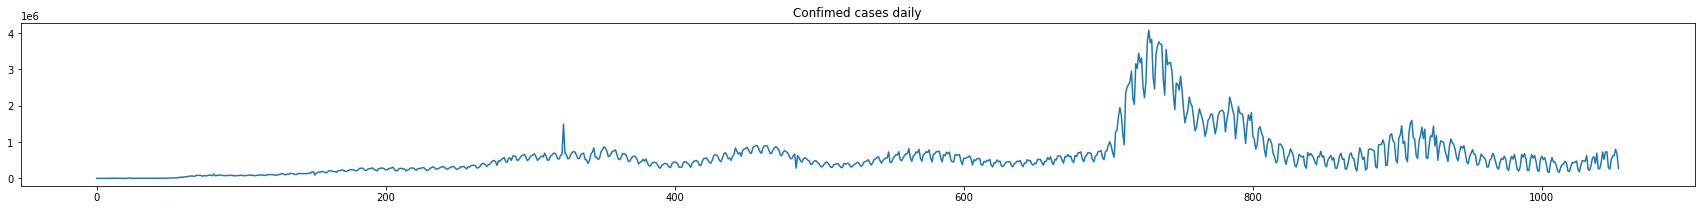

In [9]:
fig = plt.figure(figsize=(30, 3))
plt.title("Confimed cases daily")
plt.plot(range(len(conf_data_dai)),conf_data_dai[0])

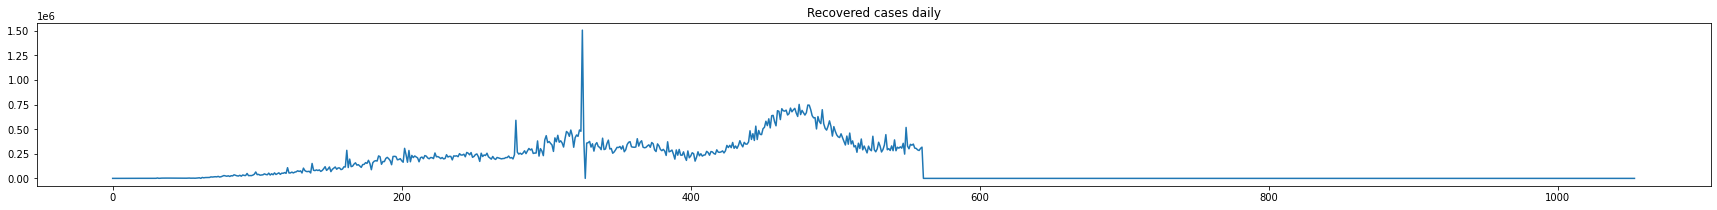

In [10]:
fig = plt.figure(figsize=(30, 3))
plt.title("Recovered cases daily")
plt.plot(range(len(reco_data_dai)),reco_data_dai[0])

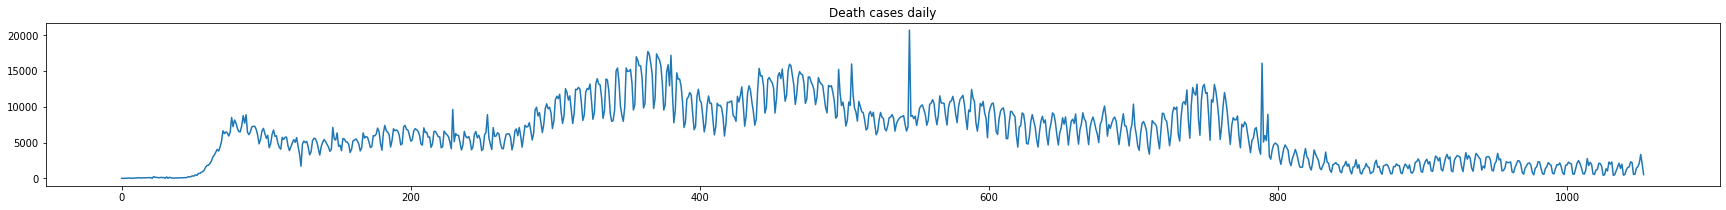

In [11]:
fig = plt.figure(figsize=(30, 3))
plt.title("Death cases daily")
plt.plot(range(len(deat_data_dai)),deat_data_dai[0])

SARIMA and ARIMA


Visualization of time-series decomposition

In [12]:
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, period = 30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(range(len(timeseries)),timeseries[0], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(range(len(trend)), trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(range(len(seasonal[:100])),seasonal[:100], label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(range(len(residual)),residual, label='Residual')
    plt.legend(loc='best')
    plt.show()

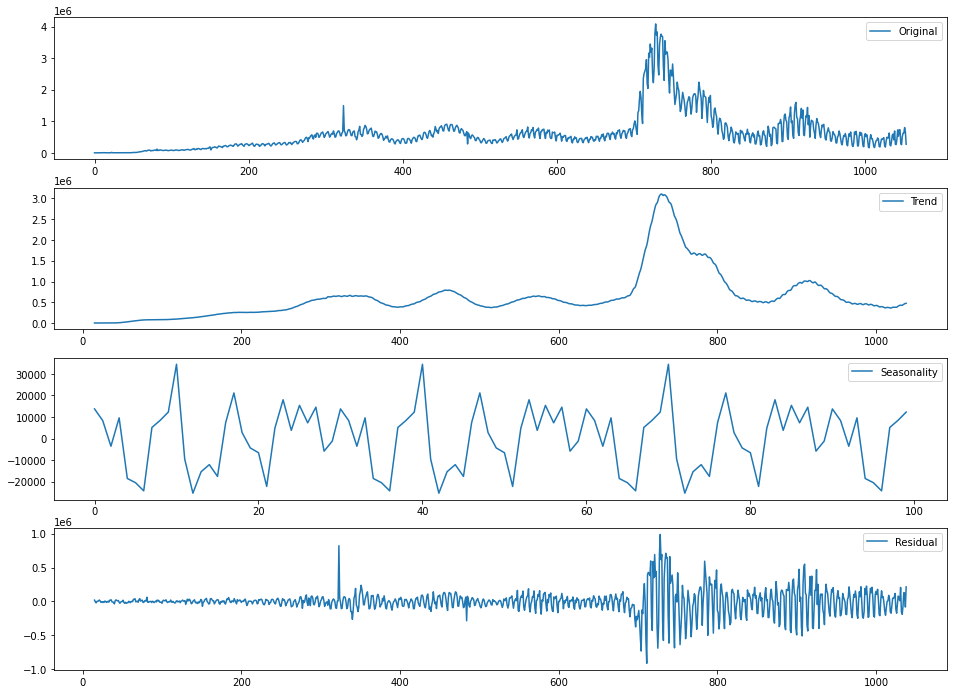

In [13]:
decomposing(conf_data_dai)

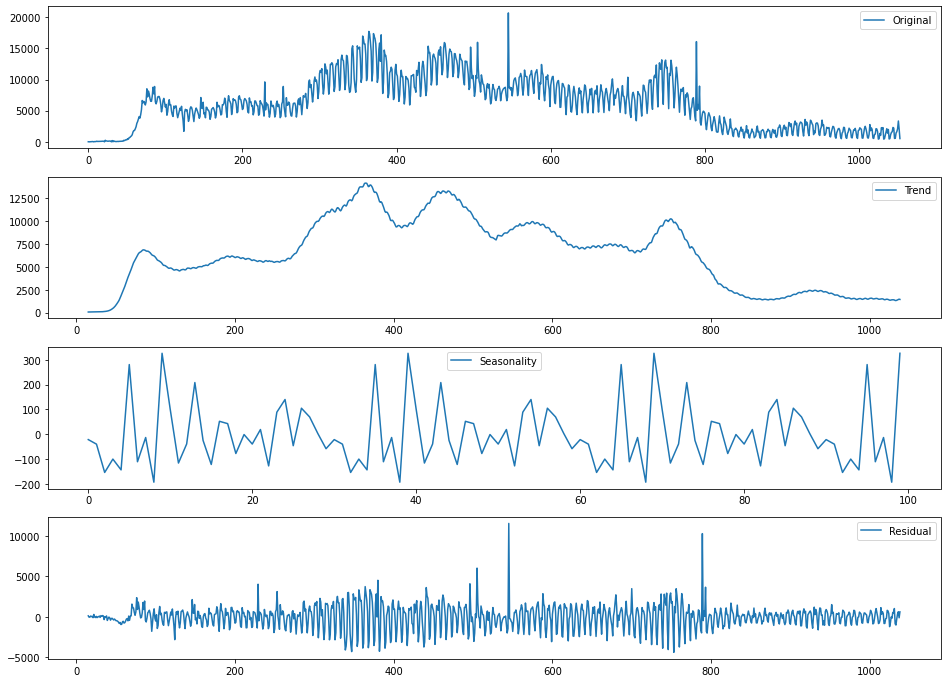

In [14]:
decomposing(deat_data_dai)

Auto-correlation

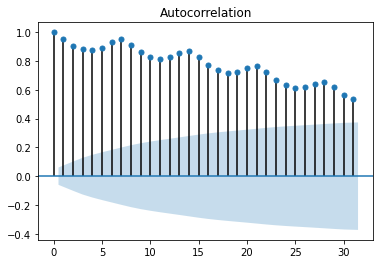

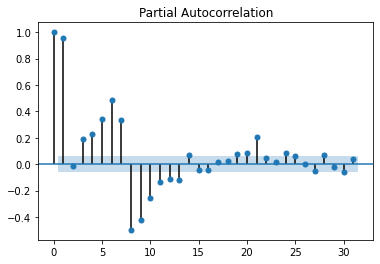

In [15]:
plot_acf(conf_data_dai).show()
plot_pacf(conf_data_dai).show()

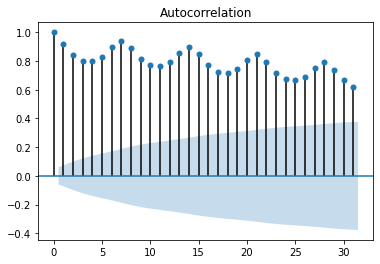

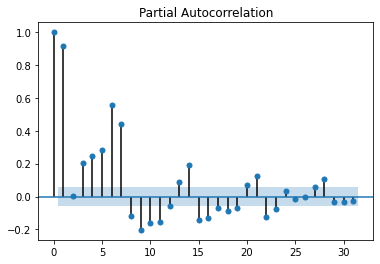

In [16]:
plot_acf(deat_data_dai).show()
plot_pacf(deat_data_dai).show()

Stationarity 

In [17]:
## p value bigger than 0.05 means not stationary
print("p_value for Death:",ADF(deat_data_dai[0])[1])
print("p_value for Confirmed:",ADF(conf_data_dai[0])[1])

p_value for Death: 0.11497883562307548
p_value for Confirmed: 0.037299319775648515


In [18]:
## for Death, make it staionary with difference
deat_diff1 = deat_data_dai.diff(1)
deat_diff2 = deat_data_dai.diff(2)
deat_diff1=deat_diff1.dropna()
deat_diff2=deat_diff2.dropna()
print("Death data after diff 1:",ADF(deat_diff1[0])[1])
print("Death data after diff 2:",ADF(deat_diff2[0])[1])
## diff 1 and diff2 have no significant difference, thus d = 1 is okay.
## for Confirmed, make it more staionary with difference
conf_diff1 = conf_data_dai.diff(1)
conf_diff2 = conf_data_dai.diff(2)
conf_diff1=conf_diff1.dropna()
conf_diff2=conf_diff2.dropna()
print("Confirmed data after diff 1:",ADF(conf_diff1[0])[1])
print("Confirmed data after diff 2:",ADF(conf_diff2[0])[1])

Death data after diff 1: 4.3868654367625706e-05
Death data after diff 2: 1.4117255155760136e-05
Confirmed data after diff 1: 2.35200531239551e-08
Confirmed data after diff 2: 5.166876127491306e-09


In [19]:
## deal with seasonality
deat_s = deat_diff1.diff(28)
conf_s = conf_diff1.diff(28)
deat_s=deat_s.dropna()
conf_s=conf_s.dropna()

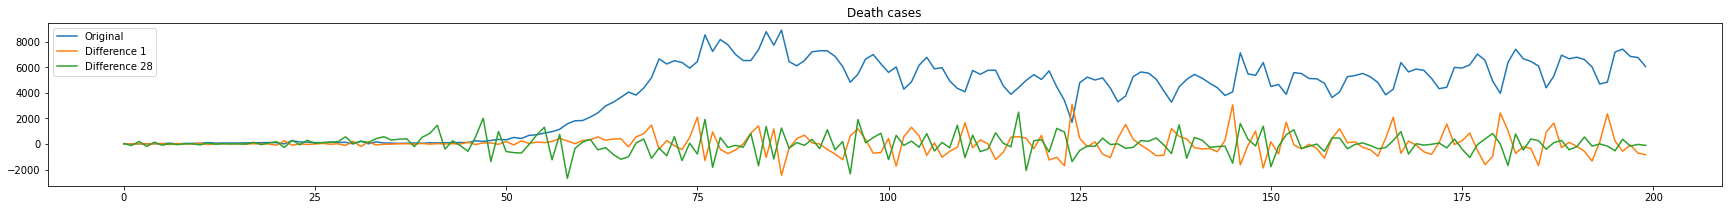

In [20]:
## plot for diff
fig = plt.figure(figsize=(30, 3))
plt.title("Death cases")
plt.plot(range(len(deat_data_dai[:200])),deat_data_dai[0][:200],label="Original")
plt.plot(range(len(deat_diff1[:200])),deat_diff1[0][:200],label="Difference 1")
#plt.plot(range(len(deat_diff2[:200])),deat_diff2[0][:200],label="diff2")
plt.plot(range(len(deat_s[:200])),deat_s[0][:200],label="Difference 28")
plt.legend()
## we can see there's almost no difference between two diff

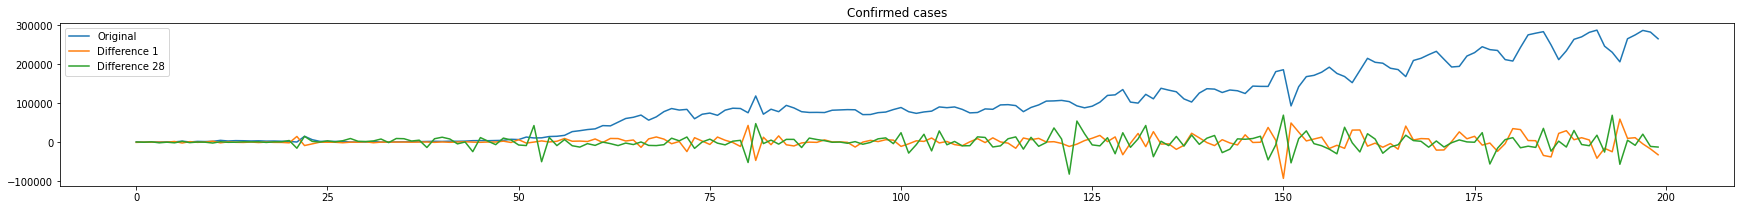

In [21]:
fig = plt.figure(figsize=(30, 3))
plt.title("Confirmed cases")
plt.plot(range(len(conf_data_dai[:200])),conf_data_dai[0][:200],label="Original")
plt.plot(range(len(conf_diff1[:200])),conf_diff1[0][:200],label="Difference 1")
#plt.plot(range(len(conf_diff2)),conf_diff2[0],label="diff2")
plt.plot(range(len(conf_s[:200])),conf_s[0][:200],label="Difference 28")
plt.legend()

Death


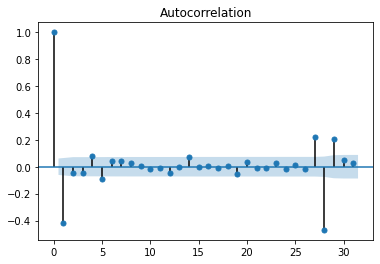

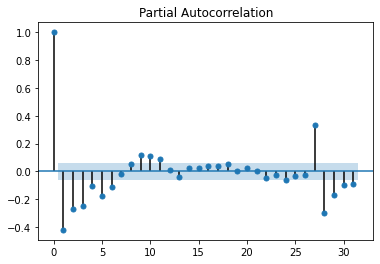

In [22]:
print("Death")
plot_acf(deat_s).show()
plot_pacf(deat_s).show()
## d = 1, D = 1
## q = 1, Q = 1
## p = 0, P = 1

Confirmed


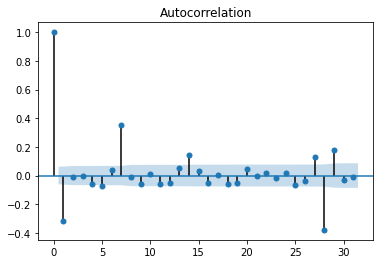

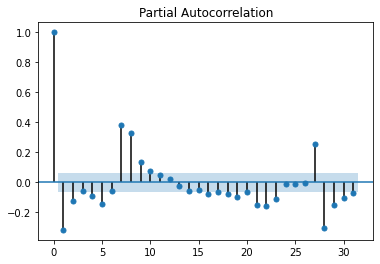

In [23]:
print("Confirmed")
plot_acf(conf_s).show()
plot_pacf(conf_s).show()
## d = 1, D = 1
## q = 8, Q = 1
## p = 0, P = 2

Train test split

In [24]:
def train_test_split(data):
  train_rate = int(0.95 * len(data[0]))
  train = list(data[0])[:train_rate]
  test = list(data[0])[train_rate:]
  return train, test

In [25]:
## death and confirmed daily data split
deat_train, deat_test = train_test_split(deat_data_dai)
conf_train, conf_test = train_test_split(conf_data_dai)

Implement model

In [68]:
#### every-step-update method
## given train set, test set and parameters
## return the prediction data of test set
def arima_esu(train, test, d, p, q):
  hist = list(train)
  pred = []
  for i in range(len(test)):
    print(i," total:",len(test))
    model = ARIMA(hist,order = (p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    #print(output)
    o = output[0]
    #print("o=",o[0])
    pred.append(o[0])
    obs = test[i]
    hist.append(obs)
  return pred

In [69]:
def arima(train, test, d, p, q):
  hist = list(train)
  pred = []
  model = ARIMA(hist,order = (p,d,q))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps = len(test))[0]
  return output

In [70]:
def one_sarima(train, test, d, p, q, D, P, Q, L):
  hist = list(train)
  pred = []
  model = sm.tsa.statespace.SARIMAX(hist,order = (p,d,q),seasonal_order=(P,D,Q,L))
  model_fit = model.fit(disp=0)
  #print(model_fit.summary())
  output = model_fit.forecast(steps = len(test))
  #print(output)
  return output, model_fit;

In [28]:
deat_pred, dmodel = one_sarima(deat_train, deat_test, 1, 6, 1, 1, 1, 1, 28)

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
conf_pred, cmodel = one_sarima(conf_train, conf_test, 1, 3, 2, 1, 3, 2, 28)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
deat_preda = arima(deat_train, deat_test, 1, 6, 1)
conf_preda = arima(conf_train, conf_test, 1, 3, 2)

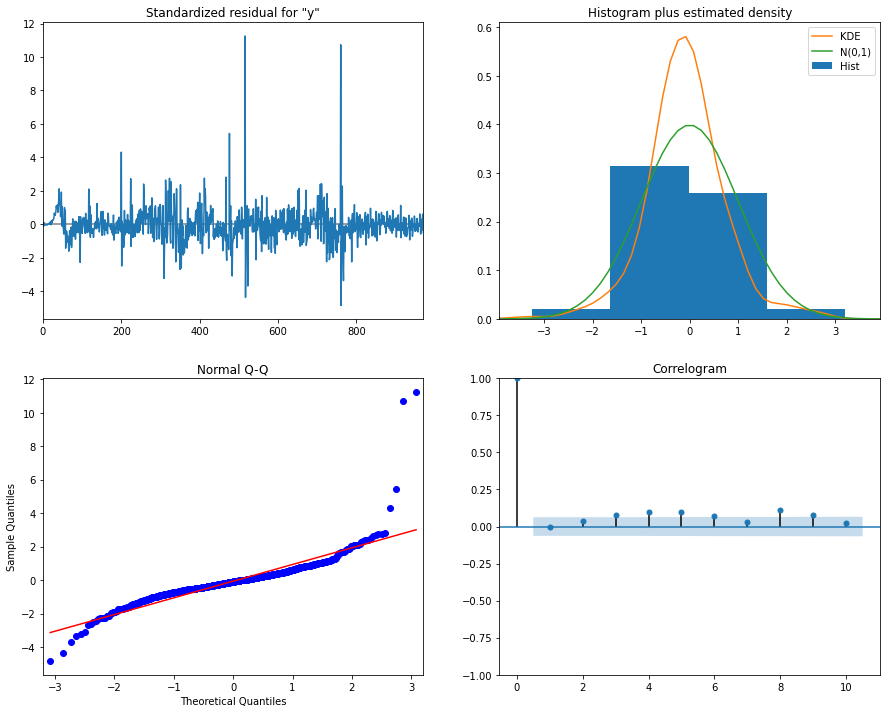

In [32]:
dmodel.plot_diagnostics(figsize=(15,12));

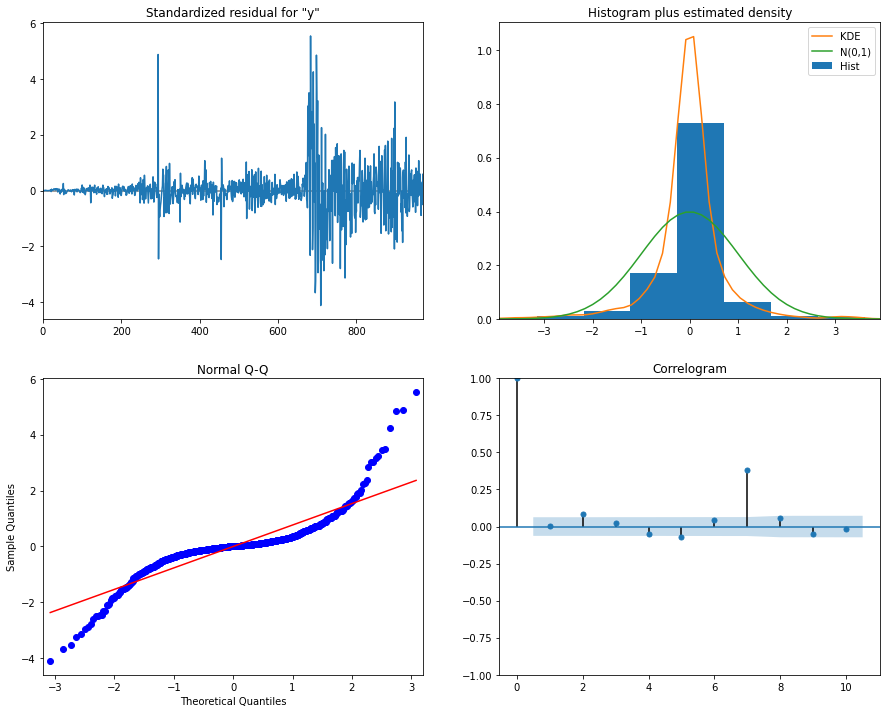

In [33]:
cmodel.plot_diagnostics(figsize=(15,12));

Prediction and plot

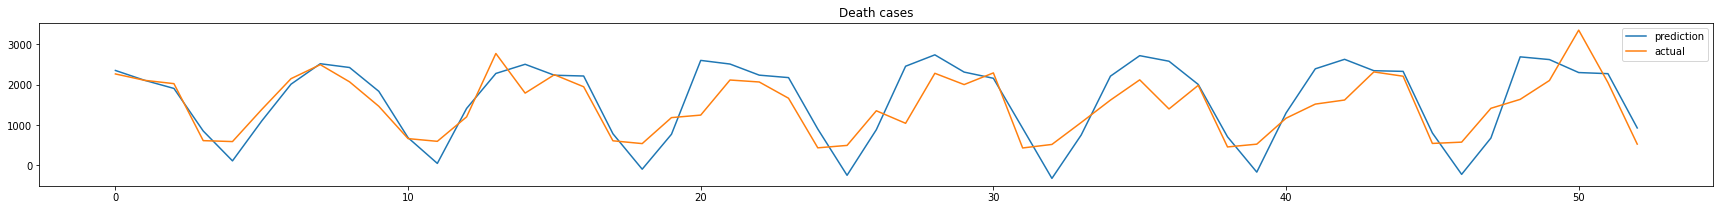

In [30]:
## plot death data
fig = plt.figure(figsize=(30, 3))
plt.title("Death cases")
plt.plot(deat_pred, label = "prediction")
plt.plot(deat_test, label = "actual")
plt.legend()

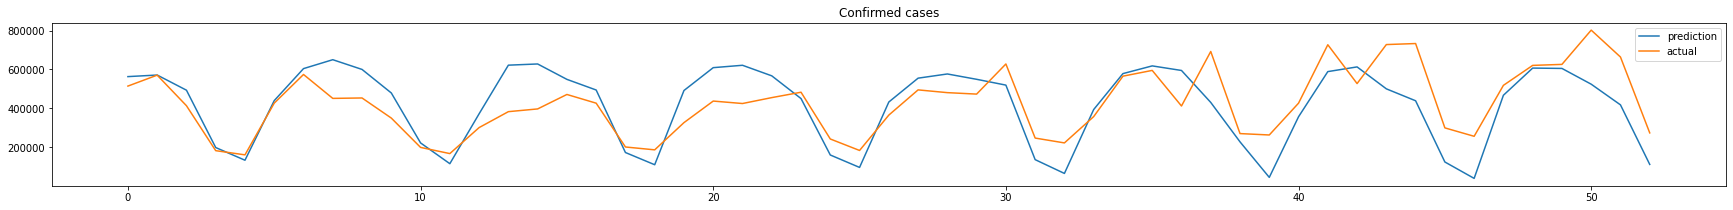

In [34]:
## plot confirmed data
fig = plt.figure(figsize=(30, 3))
plt.title("Confirmed cases")
plt.plot(conf_pred, label = "prediction")
plt.plot(conf_test, label = "actual")
plt.legend()

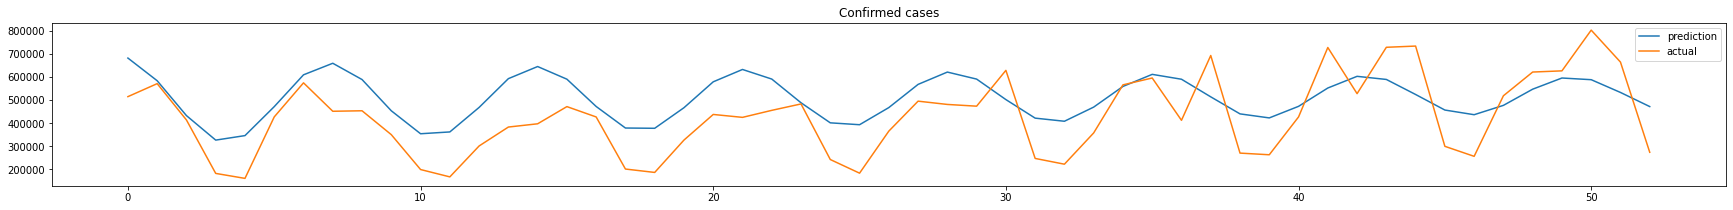

In [63]:
fig = plt.figure(figsize=(30, 3))
plt.title("Confirmed cases")
plt.plot(conf_preda, label = "prediction")
plt.plot(conf_test, label = "actual")
plt.legend()

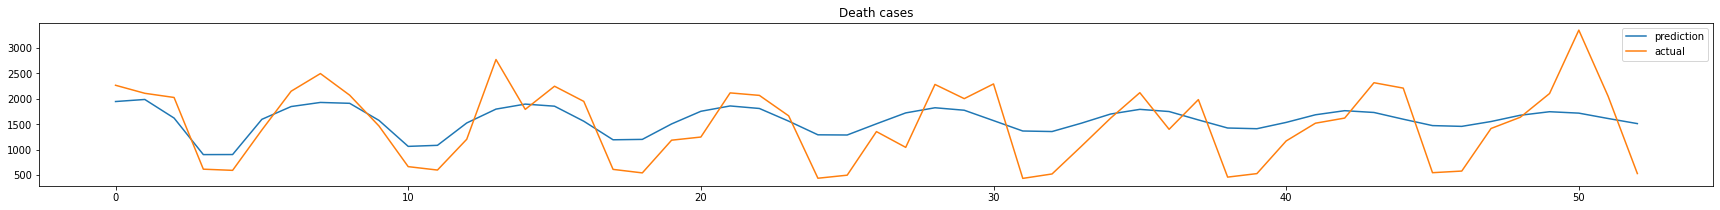

In [64]:
fig = plt.figure(figsize=(30, 3))
plt.title("Death cases")
plt.plot(deat_preda, label = "prediction")
plt.plot(deat_test, label = "actual")
plt.legend()

In [71]:
deat_preda_array = np.array(deat_preda)
deat_test_array = np.array(deat_test)
conf_preda_array = np.array(conf_preda)
conf_test_array = np.array(conf_test)

deata_mae = mean_absolute_error(deat_test_array,deat_preda_array)
confa_mae = mean_absolute_error(conf_test_array,conf_preda_array)

print("Mean absolute error of confirmed cases is: ", confa_mae)
print("Mean absolute error of death cases is: ", deata_mae)

Mean absolute error of confirmed cases is:  131425.84797865537
Mean absolute error of death cases is:  470.0988629487032


In [72]:
deat_pred_array = np.array(deat_pred)
deat_test_array = np.array(deat_test)
conf_pred_array = np.array(conf_pred)
conf_test_array = np.array(conf_test)

deat_mse = mean_squared_error(deat_test_array,deat_pred_array)
conf_mse = mean_squared_error(conf_test_array,conf_pred_array)
deat_mae = mean_absolute_error(deat_test_array,deat_pred_array)
conf_mae = mean_absolute_error(conf_test_array,conf_pred_array)
deat_mape = mean_absolute_percentage_error(deat_test_array,deat_pred_array)
conf_mape = mean_absolute_percentage_error(conf_test_array,conf_pred_array)



#print("Mean square error of confirmed cases is: ", conf_mse)
print("Mean absolute error of confirmed cases is: ", conf_mae)
#print("Root mean square error of confirmed cases is: ",((sum((conf_pred_array - conf_test_array)**2))/len(conf_pred_array))**(1/2))
#print("Mean square error of death cases is: ", deat_mse)
print("Mean absolute error of death cases is: ", deat_mae)
#print("Root mean square error death cases is: ",((sum((deat_pred_array - deat_test_array)**2))/len(deat_pred_array))**(1/2))

Mean absolute error of confirmed cases is:  110170.20673582835
Mean absolute error of death cases is:  455.67010226730616


In [51]:
print("Mean absolute percentage error of confirmed cases is: ", conf_mape)
print("Mean absolute percentage error of death cases is: ", deat_mape)

Mean absolute percentage error of confirmed cases is:  0.28483969683841515
Mean absolute percentage error of death cases is:  0.45646232500146594


In [130]:
(conf_mse)**(1/2)

94142.27697928161

Find optimal parameter

In [131]:
cp_range = range(5)
cq_range = range(5)
cP_range = range(4)
cQ_range = range(4)
dp_range = range(5)
dq_range = range(5)
dP_range = range(4)
dQ_range = range(4)

def BF_search(pr, qr, Pr, Qr, d, D, L, train):
  minb = 100000000
  minp = 0
  minq = 0
  minP = 0
  minQ = 0
  ps = []
  qs = []
  Ps = []
  Qs = []
  biccs = []
  for p in pr:
    for q in qr:
      for P in Pr:
        for Q in Qr:
          print("#",p,q,P,Q)
          try:
            model = sm.tsa.statespace.SARIMAX(train,order = (p,d,q),seasonal_order=(P,D,Q,L))
            model_fit = model.fit(disp=0)
            bicc = model_fit.bic
            #print("p:",p,"q:",q,"P:",P,"Q:",Q)
            #print("Bic:",bicc)
            if bicc< minb:
              minb = bicc
              minp = p
              minq = q
              minP = P
              minQ = Q
            if bicc<100:
              #print("p:",p,"q:",q,"P:",P,"Q:",Q)
              #print("Bic:",bicc)
              ps.append(p)
              qs.append(q)
              Ps.append(P)
              Qs.append(Q)
              biccs.append(bicc)
          except:
            continue
  print("!!!")
  print("min bicc =",minb)
  print("minp = ",minp," minq = ",minq, " minP = ",minP, "minQ = ",minQ);

  for i in range(len(ps)):
    print("p:",ps[i],"q:",qs[i],"P:",Ps[i],"Q:",Qs[i])
    print("Bic:",biccs[i])
  
  return minb,minp,minq,minP,minQ,ps,qs,Ps,Qs,biccs

In [ ]:
minb,minp,minq,minP,minQ,ps,qs,Ps,Qs,biccs = BF_search(cp_range, cq_range, cP_range, cQ_range, 1, 1, 28, conf_train[:50])

# 0 0 0 0
# 0 0 0 1


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# 0 0 0 2


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 0 0 0 3


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 0 0 1 0
# 0 0 1 1
# 0 0 1 2


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 0 0 1 3
# 0 0 2 0
# 0 0 2 1
# 0 0 2 2
# 0 0 2 3
